# Code to do Regression by Matteo

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib as plt

In [2]:
# Load data
df = pd.read_csv("preprocessed_data.csv")
df.columns = df.columns.str.strip()

# Initial exploration
print("Initial Shape:", df.shape)
print(df.info())
print(df.describe())

Initial Shape: (4269, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   no_of_dependents          4269 non-null   float64
 1   income_annum              4269 non-null   float64
 2   loan_amount               4269 non-null   float64
 3   loan_term                 4269 non-null   float64
 4   cibil_score               4269 non-null   float64
 5   residential_assets_value  4269 non-null   float64
 6   commercial_assets_value   4269 non-null   float64
 7   luxury_assets_value       4269 non-null   float64
 8   bank_asset_value          4269 non-null   float64
 9   education_ Not Graduate   4269 non-null   bool   
 10  self_employed_ Yes        4269 non-null   bool   
 11  loan_status               4269 non-null   int64  
dtypes: bool(2), float64(9), int64(1)
memory usage: 342.0 KB
None
       no_of_dependents  income

In [3]:
# Check correlation with loan_amount
correlations = df.corr(numeric_only=True)['loan_amount'].sort_values(key=abs, ascending=False)
print("Top correlated features:\n", correlations)

Top correlated features:
 loan_amount                 1.000000
income_annum                0.927470
luxury_assets_value         0.860914
bank_asset_value            0.788122
commercial_assets_value     0.603188
residential_assets_value    0.594596
cibil_score                -0.017035
loan_status                 0.016150
education_ Not Graduate    -0.010631
loan_term                   0.008437
no_of_dependents           -0.003366
self_employed_ Yes          0.001450
Name: loan_amount, dtype: float64


In [4]:
# Drop low-correlation or redundant columns (you can refine this manually too)
drop_cols = [col for col in correlations.index if abs(correlations[col]) < 0.05]
df_reduced = df.drop(columns=drop_cols)
print("Reduced shape:", df_reduced.shape)

Reduced shape: (4269, 6)


In [5]:
df_reduced.columns

Index(['income_annum', 'loan_amount', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value'],
      dtype='object')

# Data Work

In [6]:
# Load dataset
df = pd.read_csv("loan_approval_dataset.csv")
df = df.drop(columns=["loan_id"])
df.columns = df.columns.str.strip()
print(df.shape)
df.head(3)

(4269, 12)


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected


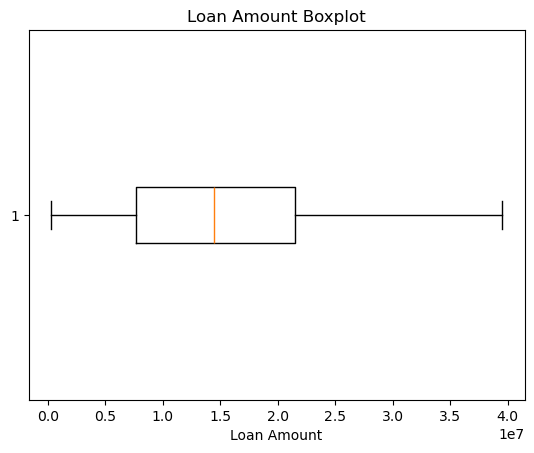

In [12]:
import matplotlib.pyplot as plt

plt.boxplot(df["loan_amount"], vert=False)
plt.title("Loan Amount Boxplot")
plt.xlabel("Loan Amount")
plt.show()

In [14]:
# Calculate IQR bounds
Q1 = df["loan_amount"].quantile(0.25)
Q3 = df["loan_amount"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Optional: see values
print(f"IQR bounds: {lower_bound:.2f} to {upper_bound:.2f}")

# Filter out outliers
df = df[(df["loan_amount"] >= lower_bound) & (df["loan_amount"] <= upper_bound)]
print(f"Original size: {len(df)}, After filtering: {len(df_filtered)}")


IQR bounds: -13000000.00 to 42200000.00
Original size: 4269, After filtering: 4269


In [6]:
# Set target for regression
y = df_reduced["loan_amount"]
X = df_reduced.drop(columns=["loan_amount"]) 

In [7]:
# Identify numeric and categorical columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns

In [8]:
# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [9]:
# Split before scaling
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [10]:
# Scale only numerical columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# XGBRegressor

In [17]:
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
grid_xgb = GridSearchCV(xgb, param_grid_xgb, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 2, 3],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [19]:
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("Best Params:", grid_xgb.best_params_)
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2_score(y_test, y_pred_xgb):.4f}")

Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
MAE: 0.29
MSE: 0.15
R²: 0.8518


# CatBoostRegressor

In [13]:
param_grid_cat = {
    'n_estimators': [50, 100, 150],
    'depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]
}

cat = CatBoostRegressor(verbose=0, random_state=42)
grid_cat = GridSearchCV(cat, param_grid_cat, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
grid_cat.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f1af81546d0>,
             n_jobs=-1,
             param_grid={'depth': [3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [14]:
best_cat = grid_cat.best_estimator_
y_pred_cat = best_cat.predict(X_test)

print("Best Params:", grid_cat.best_params_)
mae = mean_absolute_error(y_test, y_pred_cat)
mse = mean_squared_error(y_test, y_pred_cat)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2_score(y_test, y_pred_cat):.4f}")

Best Params: {'depth': 4, 'learning_rate': 0.05, 'n_estimators': 150}
MAE: 0.29
MSE: 0.15
R²: 0.8500


# MLPregressor

In [15]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.005]
}

mlp = MLPRegressor(max_iter=10000, random_state=42)
grid_mlp = GridSearchCV(mlp, param_grid_mlp, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
grid_mlp.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(50,), (100,), (100, 50)],
                         'learning_rate_init': [0.001, 0.01, 0.005]},
             scoring='neg_mean_squared_error', verbose=2)

In [16]:
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

print("Best Params:", grid_mlp.best_params_)
mae = mean_absolute_error(y_test, y_pred_mlp)
mse = mean_squared_error(y_test, y_pred_mlp)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2_score(y_test, y_pred_mlp):.4f}")

Best Params: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
MAE: 0.29
MSE: 0.15
R²: 0.8516


# Mistake Comparison - helped by GPT

In [20]:
# Create a DataFrame to hold all predictions and errors
comparison_df = pd.DataFrame({
    'y_true': y_test,
    'CatBoost': y_pred_cat,
    'MLP': y_pred_mlp,
    'XGBoost': y_pred_xgb
})

# Add absolute error columns
comparison_df['CatBoost_err'] = np.abs(comparison_df['y_true'] - comparison_df['CatBoost'])
comparison_df['MLP_err'] = np.abs(comparison_df['y_true'] - comparison_df['MLP'])
comparison_df['XGBoost_err'] = np.abs(comparison_df['y_true'] - comparison_df['XGBoost'])

# Optional: See rows where all 3 models have identical predictions
same_preds = (np.isclose(comparison_df['CatBoost'], comparison_df['MLP'])) & \
             (np.isclose(comparison_df['MLP'], comparison_df['XGBoost']))

# Rows where all models predicted the same (within rounding tolerance)
identical_pred_rows = comparison_df[same_preds]

# Or, rows where all models made large errors (e.g., > 10 million)
bad_rows = comparison_df[
    (comparison_df['CatBoost_err'] > 1e7) &
    (comparison_df['MLP_err'] > 1e7) &
    (comparison_df['XGBoost_err'] > 1e7)
]

# View examples
print("Rows where all 3 models made the same prediction:")
print(identical_pred_rows)

print("\nRows where all 3 models made large errors:")
print(bad_rows)

Rows where all 3 models made the same prediction:
Empty DataFrame
Columns: [y_true, CatBoost, MLP, XGBoost, CatBoost_err, MLP_err, XGBoost_err]
Index: []

Rows where all 3 models made large errors:
Empty DataFrame
Columns: [y_true, CatBoost, MLP, XGBoost, CatBoost_err, MLP_err, XGBoost_err]
Index: []


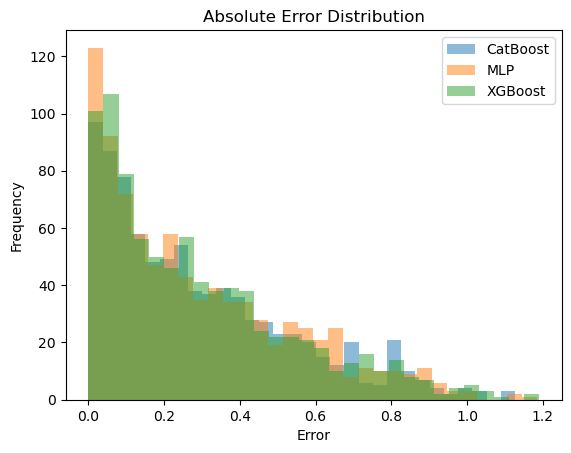

In [21]:
import matplotlib.pyplot as plt

plt.hist(comparison_df['CatBoost_err'], bins=30, alpha=0.5, label='CatBoost')
plt.hist(comparison_df['MLP_err'], bins=30, alpha=0.5, label='MLP')
plt.hist(comparison_df['XGBoost_err'], bins=30, alpha=0.5, label='XGBoost')
plt.legend()
plt.title("Absolute Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


In [22]:
comparison_df['worst_model'] = comparison_df[
    ['CatBoost_err', 'MLP_err', 'XGBoost_err']
].idxmax(axis=1)
print(comparison_df['worst_model'].value_counts())


worst_model
CatBoost_err    323
MLP_err         285
XGBoost_err     246
Name: count, dtype: int64


In [23]:
disagreement_rows = comparison_df[
    ~np.isclose(comparison_df['CatBoost'], comparison_df['MLP']) |
    ~np.isclose(comparison_df['MLP'], comparison_df['XGBoost']) |
    ~np.isclose(comparison_df['CatBoost'], comparison_df['XGBoost'])
]
print("Disagreement rows:", disagreement_rows.shape[0])


Disagreement rows: 854
